In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import statsmodels.tsa.api as smt
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

In [2]:
data = pd.read_csv('data/Annual precipitation inches Lake Huron 1900 to 1986.csv',names=["year","x"], skiprows=1)

In [52]:
data.describe()

,year,x
count,87.000000,87.000000
mean,44.000000,31.898391
std,25.258662,3.319027
min,1.000000,25.830000
25%,22.500000,30.000000
50%,44.000000,31.420000
75%,65.500000,33.940000
max,87.000000,42.360000


In [18]:
data.head()

,year,x
0,1,31.42
1,2,30.28
2,3,33.21
3,4,33.98
4,5,31.07


Удалим тренд и сезонность ручками. Потом попроверяем на стационарность

In [7]:
nottrend = []
s = 8
notseason = []

# выборка без тренда
for i in range(1, len(data["x"])):
   nottrend.append(data["x"][i] - data["x"][i-1])

# выборка без сезонности
for i in range(s, len(data["x"])):
   notseason.append(data["x"][i] - data["x"][i-s])


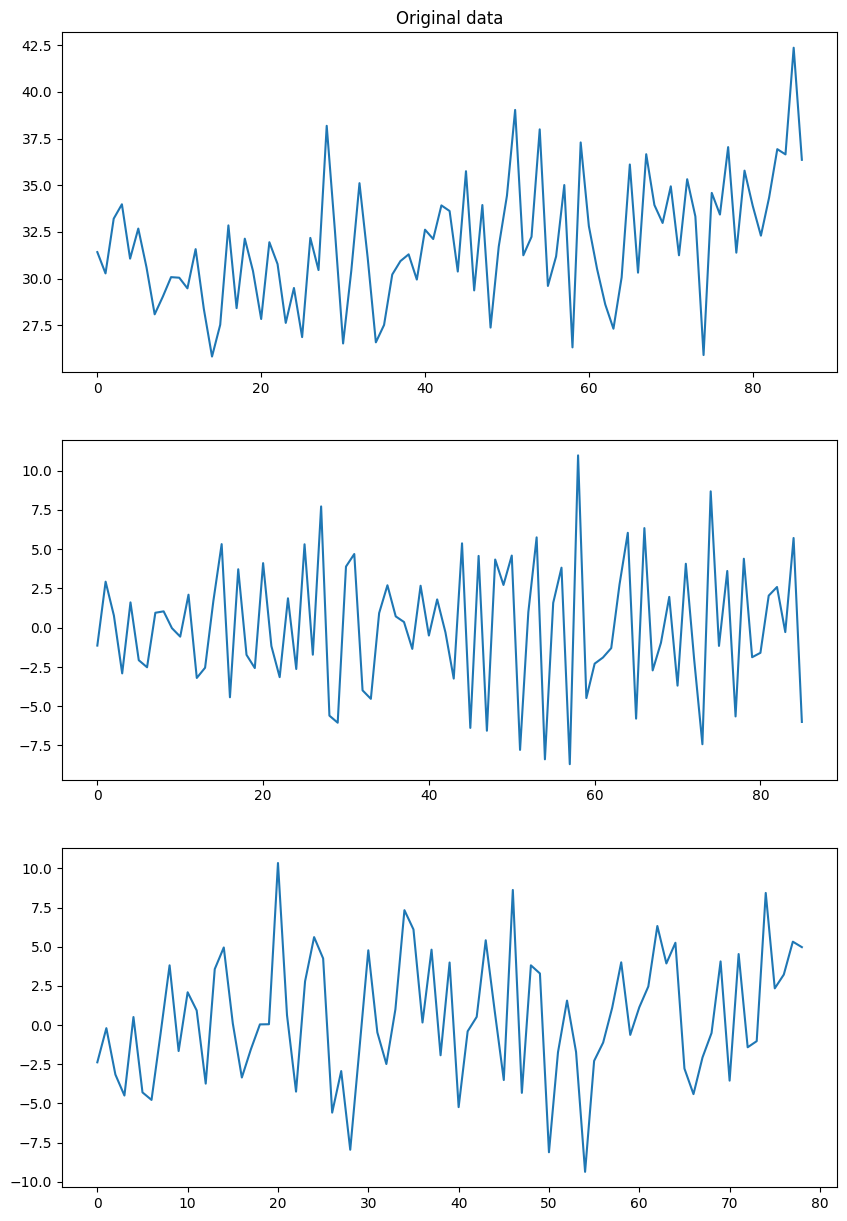

In [8]:
fig, axs = plt.subplots(3,1,figsize = (10,15))
axs[0].plot(data['x'])
axs[0].set_title('Original data')
axs[1].plot(nottrend)
axs[2].plot(notseason)

In [10]:
def stationary_test(ts, name):
    alpha = 0.05
    
    print(f'Тест Дики-Фуллера ряда {name} :')
    datatest = adfuller(ts, autolag='AIC')
    dataoutput = pd.Series(datatest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in datatest[4].items():
        dataoutput['Critical Value (%s)'%key] = value
    print(dataoutput)

    if dataoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [23]:
stationary_test(data['x'], 'Осадки')

Тест Дики-Фуллера ряда Осадки :
Test Statistic                 -4.348189
p-value                         0.000366
#Lags Used                      1.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [24]:
stationary_test(nottrend, 'Осадки без тренда')

Тест Дики-Фуллера ряда Осадки без тренда :
Test Statistic                -7.607071e+00
p-value                        2.307137e-11
#Lags Used                     3.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


In [25]:
stationary_test(notseason, 'Осадки без сезонности')

Тест Дики-Фуллера ряда Осадки без сезонности :
Test Statistic                 -5.560125
p-value                         0.000002
#Lags Used                      7.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Преобразование бокса-Кокса

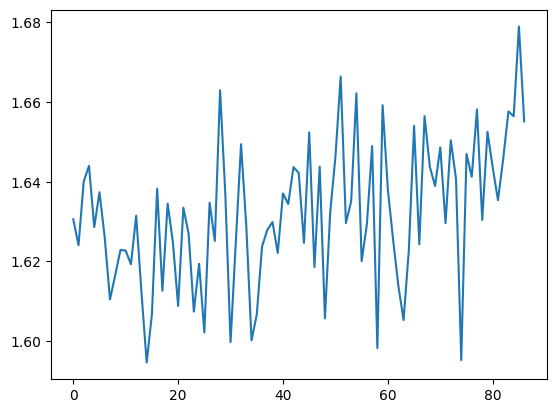

In [55]:
transformed_data, best_lambda = boxcox(data["x"]) 

# а теперь посмотрим на преобразованные данные
plt.plot(transformed_data)

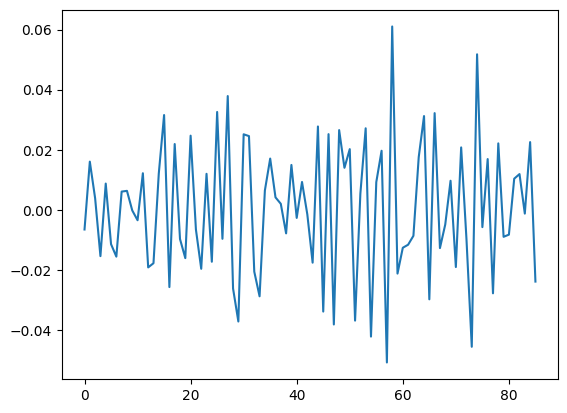

In [56]:
pnottrend = []

for i in range(1, len(transformed_data)):
   pnottrend.append(transformed_data[i] - transformed_data[i-1])


plt.plot(pnottrend) 

In [59]:
stationary_test(pnottrend, 'Бокс-Кокс осадки')

Тест Дики-Фуллера ряда Бокс-Кокс осадки :
Test Statistic                -7.815100e+00
p-value                        6.903735e-12
#Lags Used                     3.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


Коррелограмма

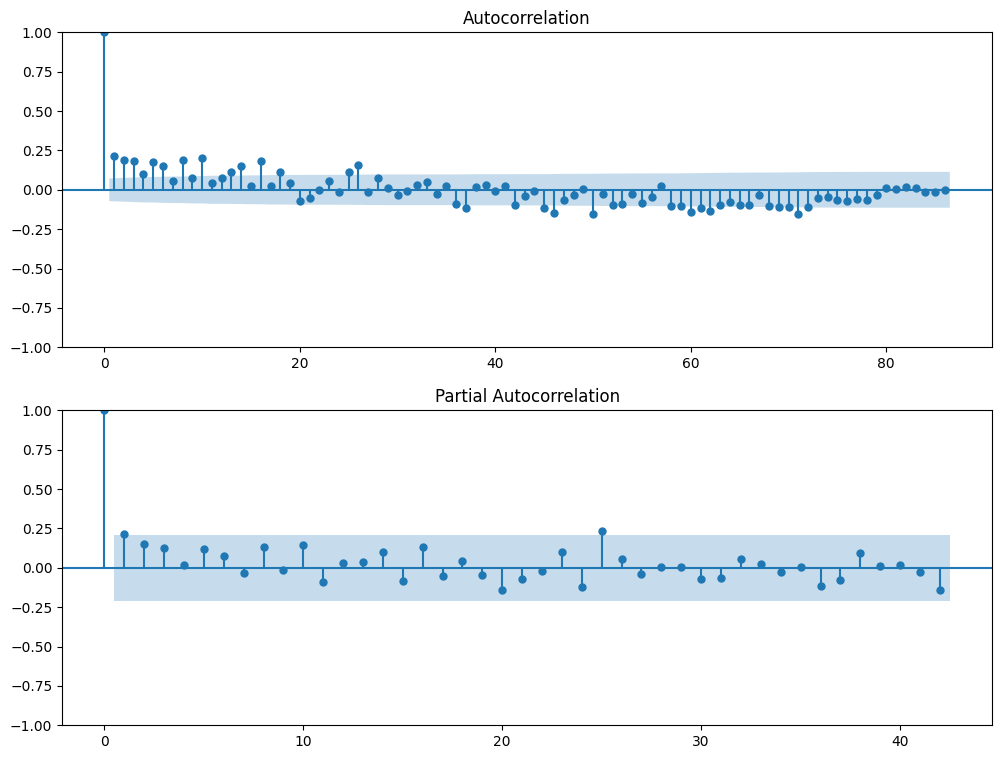

In [21]:
ts = data["x"]

fig, axs = plt.subplots(2,1,figsize=(12,9))

axs[0] = smt.graphics.plot_acf(ts, lags=len(ts)-1, alpha=0.5, ax = axs[0])

axs[1] = smt.graphics.plot_pacf(ts, lags=len(ts)/2-1, ax = axs[1])

plt.show()

Следаем прогноз с помощью AR модели, предварительно поделив выборки на обучающую, валидационную и тестовую.

In [3]:
ln = len(data)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.90,0))

# делим выборки
train_df = data[data['year'] <= train_cutoff]
validate_df = data[(data['year'] > train_cutoff) & (data['year'] <= validate_cutoff)]
forecast_df = data[data['year'] > validate_cutoff]

Визуализируем поделенные выборки.

* Обучающая выборка - синим цветом
* Валидационная выборка - оранжевым цветом
* Предсказываемая выборка - зеленым цветом

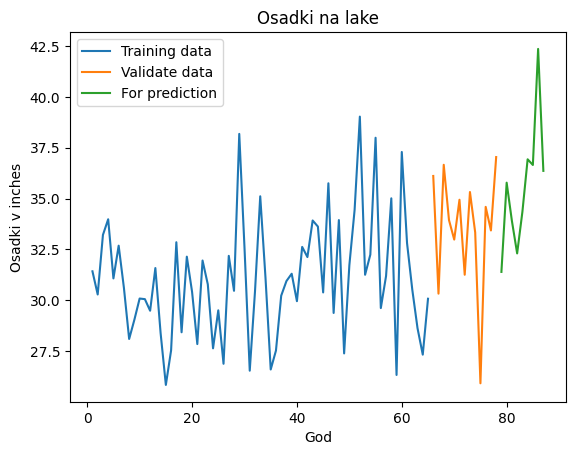

In [37]:
plt.plot(train_df.year, train_df.x, label='Training data')
plt.plot(validate_df.year, validate_df.x, label='Validate data')
plt.plot(forecast_df.year, forecast_df.x, label='For prediction')
plt.legend()
plt.title('Osadki na lake')
plt.ylabel('Osadki v inches')
plt.xlabel('God')
plt.show()

In [5]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [37]:
# создаем объект модели на основе данных временного ряда с 3 лагами
mod = AutoReg(data.x, 3, old_names=False)
# обучаем

res = mod.fit()

# выводим сводку информации об авторегрессионной модели
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   87
Model:                     AutoReg(3)   Log Likelihood                -216.393
Method:               Conditional MLE   S.D. of innovations              3.181
Date:                Thu, 12 Oct 2023   AIC                            442.786
Time:                        22:13:00   BIC                            454.940
Sample:                             3   HQIC                           447.671
                                   87                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0818      5.255      3.060      0.002       5.781      26.382
x.L1           0.1652      0.108      1.532      0.126      -0.046       0.376
x.L2           0.1690      0.114      1.485      0.1

In [38]:
# опять обучаем модель, но на этот раз указываем тип ковариационной оценки
res = mod.fit(cov_type="HC0")

# смотрим, что изменилось
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   87
Model:                     AutoReg(3)   Log Likelihood                -216.393
Method:               Conditional MLE   S.D. of innovations              3.181
Date:                Thu, 12 Oct 2023   AIC                            442.786
Time:                        22:13:02   BIC                            454.940
Sample:                             3   HQIC                           447.671
                                   87                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0818      5.142      3.127      0.002       6.003      26.160
x.L1           0.1652      0.098      1.680      0.093      -0.027       0.358
x.L2           0.1690      0.118      1.433      0.1

In [39]:
pred = res.predict(start=0, end=train_cutoff-1, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(len(data.x)), dynamic=False)

In [1]:
plt.plot(train_df.year, train_df.x, label='Training data')
plt.plot(validate_df.year, validate_df.x, label='Validate data')
plt.plot(forecast_df.year, forecast_df.x, label='For prediction')
plt.plot(validate_df.year, v_pred, label='Validate prediction ')
plt.plot(forecast_df.year, f_pred, label='Forecast prediction')
plt.plot(train_df.year, pred, label='Train prediction')

plt.legend()
plt.title('Osadki na lake')
plt.ylabel('Osadki v inches')
plt.xlabel('God')
plt.show()

NameError: name 'plt' is not defined

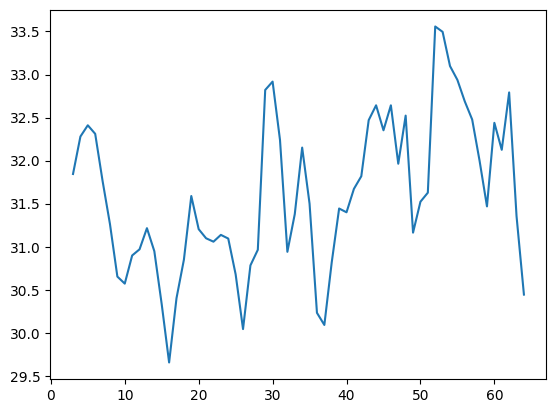

In [100]:
plt.plot(pred)

Я оставлю этот график м единственной целью, он хотя бы не константа. Я имею ввиду там дальше будет лучшее предсказание на свете, а это хоть красивенькое

In [18]:
sel = ar_select_order(data.x, old_names=False, maxlag=20)
print(sel.ar_lags)
res2 = sel.model.fit()
print(res2.summary())

None
                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   87
Model:                     AutoReg(0)   Log Likelihood                -227.316
Method:               Conditional MLE   S.D. of innovations              3.300
Date:                Fri, 13 Oct 2023   AIC                            458.632
Time:                        15:21:02   BIC                            463.564
Sample:                             0   HQIC                           460.618
                                   87                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.8984      0.354     90.163      0.000      31.205      32.592


In [16]:
data.x

0     31.42
1     30.28
2     33.21
3     33.98
4     31.07
      ...  
82    34.34
83    36.93
84    36.65
85    42.36
86    36.36
Name: x, Length: 87, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


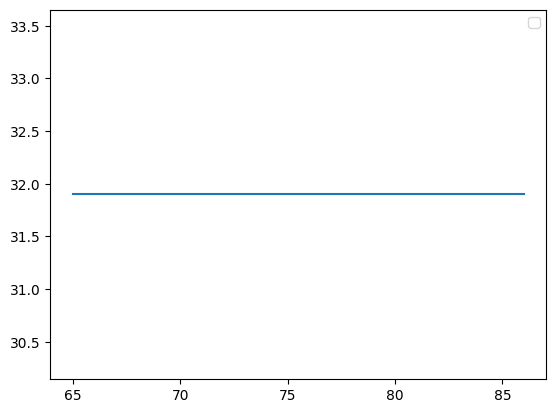

In [14]:
fig = res2.plot_predict(train_cutoff)

In [12]:
train_cutoff

65

Вот эта вот гениальная модель посчитала что константы это круто, ну ей видней

In [8]:
pred2 = res2.predict(start=0, end=train_cutoff-1, dynamic=False)
v_pred2 = res2.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred2 = res2.predict(start=validate_cutoff + 1, end=(len(data.x)), dynamic=False)

In [2]:
plt.plot(train_df.year, train_df.x, label='Training data')
plt.plot(validate_df.year, validate_df.x, label='Validate data')
plt.plot(forecast_df.year, forecast_df.x, label='For prediction')
plt.plot(validate_df.year, v_pred2, label='Validate prediction ')
plt.plot(forecast_df.year, f_pred2, label='Forecast prediction')
plt.plot(train_df.year, pred2, label='Train prediction')

plt.legend()
plt.title('Osadki na lake')
plt.ylabel('Osadki v inches')
plt.xlabel('God')
plt.show()

NameError: name 'plt' is not defined

Скользящее среднее

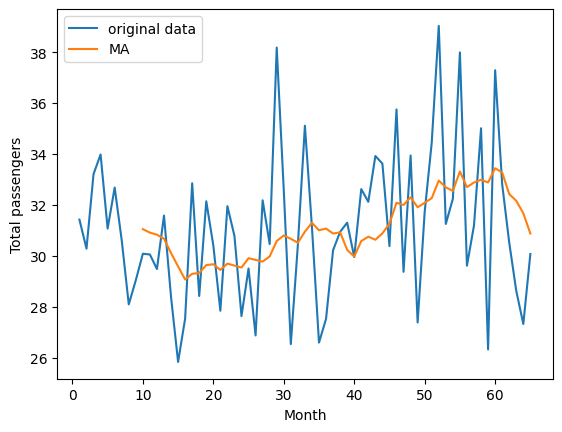

In [102]:
plt.plot(train_df["year"], train_df["x"], label="original data")
plt.plot(train_df["year"], train_df["x"].rolling(10).mean(), label="MA")
plt.legend()
plt.title('Osadki na lake')
plt.ylabel('Osadki v inches')
plt.xlabel('God')
plt.show()

## Метрики точности прогноза <a class="anchor" id="metrics"></a>

In [4]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [29]:
def smape( data , pred ):
 return 1/ len (data) * np.sum (2 * np.abs (pred-data) / (np.abs (data) + np.abs (pred)))

Для неконстантной модели

In [44]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred))
print("R2: ", r2_score(forecast_df.x, f_pred))
print("SMAPE: ", smape(forecast_df.x, f_pred))

RMSE: 3.038775506952574
MAPE: 0.06478230081466109
MAE: 2.4131522873406226
R2:  -0.010377748321583224
SMAPE:  0.06833595291979314


Для константной модели

In [42]:
print("RMSE:", np.sqrt(mean_squared_error(forecast_df.x, f_pred2)))
print("MAPE:", mean_absolute_percentage_error(forecast_df.x, f_pred2))
print("MAE:", mean_absolute_error(forecast_df.x, f_pred2))
print("R2: ", r2_score(forecast_df.x, f_pred2))
print("SMAPE: ", smape(forecast_df.x, f_pred2))

RMSE: 4.7457658385246475
MAPE: 0.10031463465225177
MAE: 3.7712515964240114
R2:  -1.4643316241555762
SMAPE:  0.10656816638945384
